(chapter2:reinforce_implementation:title)=
# REINFORCE 구현

## `Gymnaisum` 사용법

먼저 강화학습 코딩이 처음인 분들에게는 에이전트가 환경과 상호작용하는 것부터 어떻게 구현해야 할지 막막할 것이다. `Gymnaisum`은 다양한 연습용 환경을 제공하고 있으며, 강화학습 연구자들에게 환경을 구현하기 위한 일종의 약속 (convention)을 제공하고 있다. 이번 절에서 `Gymnaisum`에서 제공하고 있는 CartPole 환경을 사용해볼 것이다.

<br>

먼저 실습에 사용할 라이브러리들을 모두 임포트 하자.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from torch.distributions import Normal

<br>

`gymnasium.make('환경이름')`을 통해 환경을 불러올 수 있다. `Gymnasium`에서 제공하는 환경의 목록은 `Gymnasium`의 [공식 문서](https://gymnasium.farama.org/environments/classic_control/)에 잘 나와 있다.

In [2]:
env = gym.make('CartPole-v1')

<br>

환경 초기화는 `env.reset()` 메서드를 사용하여 할 수 있다. 초기 상태 $s_0 \sim \rho_0$에 대응하는 코드이다. 이 메서드를 호출하면 환경의 초기 상태와 주로 학습에 사용되지는 않지만 사용자가 알면 좋은 추가 정보를 반환해준다.


In [3]:
s, info = env.reset()

print("Initial state is: ", s)
print("Information: ", info)

Initial state is:  [-0.03165545 -0.03685457  0.03814746  0.03831236]
Information:  {}


<br>

환경의 상태를 관찰하였으니, 아무 행동을 뽑아서 환경에 행동을 취해보자. `env.action_space.sample()`은 행동 공간에서 임의의 행동 하나를 반환해주는 메서드이다. 다음으로 `env.step(action)`을 통해 환경에 행동을 취할 수 있다. `env.step(action)`은 5-tuple인 `(s_prime, r, terminated, truncated, info)`을 반환해준다.
- `s_prime`: 다음 상태
- `r`: 보상
- `terminated`: 환경이 종료 조건에 의해 종료되었는지 여부
- `truncated`: 환경이 최대 상호작용 횟수에 도달하여 종료되었는지 여부
- `info`: 추가 정보


In [4]:
# Choose a random action
a = env.action_space.sample()  

# Take the action
s_prime, r, terminated, truncated, info =  env.step(a)

print("Next state: ", s_prime)
print("Reward: ", r)
print("Is terminated? ", terminated)
print("Is truncated? ", truncated)
print("Information: ", info)

Next state:  [-0.03239254 -0.2325022   0.03891371  0.34278294]
Reward:  1.0
Is terminated?  False
Is truncated?  False
Information:  {}


```{note}
`terminated`와 `truncated`은 둘 다 환경이 종료되었는지 여부를 반환해준다. 단, `terminated`은 종료 조건에 의해 환경이 종료되었을 때 `True`를 반환한다. 종료 조건의 예시는 주로 에이전트가 목적을 달성했거나, 사망이나 붕괴 등 돌이킬 수 없는 상태에 빠졌을 경우를 의미한다. `truncated`은 주로 환경의 종료 조건이 따로 없는 경우에만 의미가 있다. 로봇 통제와 같은 무한히 상호작용할 수 있는 환경의 경우, 실제 구현에서는 평생 상호작용할 수 없으니 1000회 정도 상호작용 후 환경을 마친다. 이처럼 최대 상호작용 횟수에 도달하여 환경이 종료된 경우 `truncated`와 `True`를 반환한다 
```

<br>

위의 내용을 종합하면, 한 에피소드 진행은 다음과 같이 구현한다.

In [5]:
s, terminated, truncated, ret = env.reset(), False, False, 0
while not (terminated or truncated):
    a = env.action_space.sample()
    s_prime, r, terminated, truncated, _ = env.step(a)
    
    ret += r
    s = s_prime
print("Return: ", ret)

Return:  11.0


<br>

---

## 이산 행동 공간

### 정책 네트워크 구현

다음으로 정책 네트워크를 정의해보자. 정책은 주어진 상태 $s$에서 행동 $a$를 취한 조건부 확률 $\text{Pr}\left[A=a|S=s \right]$이다. 
각 상태 $s$마다 조건부 확률 분포가 정의되어야 하므로 정책 네트워크는 상태를 입력 받는다. 그리고 행동에 대한 확률 분포이기 때문에 각 행동에 확률을 부여해야 한다.

CartPole 환경은 4차원 행동을 입력 받고 2가지 행동 중 선택하는 이산 행동 공간을 가지기 때문에 4차원 벡터를 입력 받고 2차원 벡터를 출력하는 다층퍼셉트론 (MLP)로 정의하되, 출력이 확률 분포로 해석할 수 있도록 출력에 softmax 함수를 씌울 것이다. 이 MLP 나중에 다양한 실험을 위해서 다소 일반적으로 코드를 짰다. 일반적이라는 의미는 사용자의 수요에 맞게 히든레이어 개수 및 노드 수를 조정할 수 있고 활성화 함수도 설정할 수 있도록 만들었다.

In [6]:
class MLPDiscretePolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPDiscretePolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, s):
        s = self.activation_fn(self.input_layer(s))
        for hidden_layer in self.hidden_layers:
            s = self.activation_fn(hidden_layer(s))
        prob = F.softmax(self.output_layer(s), dim=-1)

        return prob

<br>

정책 네트워크를 다음과 같이 선언할 수 있다.

In [7]:
env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dims = (128, 128)
activation_fn = F.relu

policy = MLPDiscretePolicy(state_dim, action_dim, hidden_dims, activation_fn)
policy

MLPDiscretePolicy(
  (input_layer): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)

<br>

정책 네트워크에 상태 하나를 입력하면 다음과 같이 출력된다. 결과로 나온 벡터의 각 원소는 각 행동을 취할 확률로 해석할 수 있다.

In [8]:
s, _ = env.reset()
s = torch.as_tensor(s, dtype=torch.float)

policy(s)

tensor([0.4848, 0.5152], grad_fn=<SoftmaxBackward0>)

<br>

정책 네트워크로 만든 확률 분포에서 행동을 샘플링은 다음과 같이 할 수 있다.

In [9]:
prob = policy(s)
a = torch.multinomial(prob, num_samples=1)
print("Selected action : ", a.item())

Selected action :  1


<br>

### 에이전트 구현

정책 네트워크가 준비되었으니 REINFORCE 에이전트를 만들어보자. REINFORCE 에이전트는 총 4개 메서드가 있다. 
- `__init__()`: 에이전트 클래스가 입력 받을 하이퍼파라미터를 입력 받고 여러가지 초기화를 수행한다.
- `act()`: 환경과의 상호작용을 위한 메서드로서 상태 하나를 입력 받아 행동을 출력한다.
- `learn()`: 에이전트가 갖고 있는 네트워크들을 업데이트해준다.
- `process()`: 환경과의 매 상호작용마다 수행할 메서드이다. 주로 transition을 버퍼에 저장하고, 특정 주기로 `learn()` 메서드를 호출한다.

이 메서드 구성은 카카오 엔터프라이즈의 강화학습 라이브러리 [JORLDY](https://github.com/kakaoenterprise/JORLDY)를 참고하여 만들었다. 이후 구현할 알고리즘들도 동일한 메서드 구성을 갖고 있다. 알고리즘마다 각 메서드가 어떻게 구현되는지에 초점을 맞춰 비교하면 좋을 것 같다.

In [10]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.001):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPDiscretePolicy(state_dim, action_dim).to(self.device)
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.buffer = []
        
    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        prob = self.policy(s)
        a = torch.multinomial(prob, 1) if training else torch.argmax(prob, dim=-1, keepdim=True)

        return a.cpu().numpy()

    def learn(self):
        self.policy.train()
        s, a, r, _, _, _ = map(np.stack, zip(*self.buffer))
        s, a, r = map(lambda x: torch.as_tensor(x, dtype=torch.float, device=self.device), [s, a, r])
        a = a.long()
        r = r.unsqueeze(1)
        
        ret = torch.clone(r)
        for t in reversed(range(len(ret) - 1)):
            ret[t] += self.gamma * ret[t + 1]
            
        probs = self.policy(s)
        log_probs = torch.log(probs.gather(1, a.long()))
        
        policy_loss = - (ret * log_probs).mean()
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        result = {'policy_loss': policy_loss.item()}
        
        return result
        
    def process(self, transition):
        result = None
        self.buffer.append(transition)
        if transition[-1] or transition[-2]:
            result = self.learn()
            self.buffer = []
        return result

<br>

(cartpole-reinforce)=
### 에이전트 훈련

REINFORCE 클래스 작성을 마쳤으니 이제 환경과 상호작용을 하면서 정책 네트워크를 훈련시킬 차례이다.

In [11]:
def evaluate(env_name, agent, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for _ in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=np.random.randint(10000)), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(a[0])
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [12]:
env_name = 'CartPole-v1'

seed = 0
max_iterations = 100000
eval_intervals = 5000
eval_iterations = 10
gamma = 0.99
lr = 0.001

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, action_dim, gamma, lr)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in range(1, max_iterations + 1):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a[0])
    result = agent.process((s, a, r, s_prime, terminated, truncated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

<br>

훈련 로그를 시각화해보면 다음과 같다.

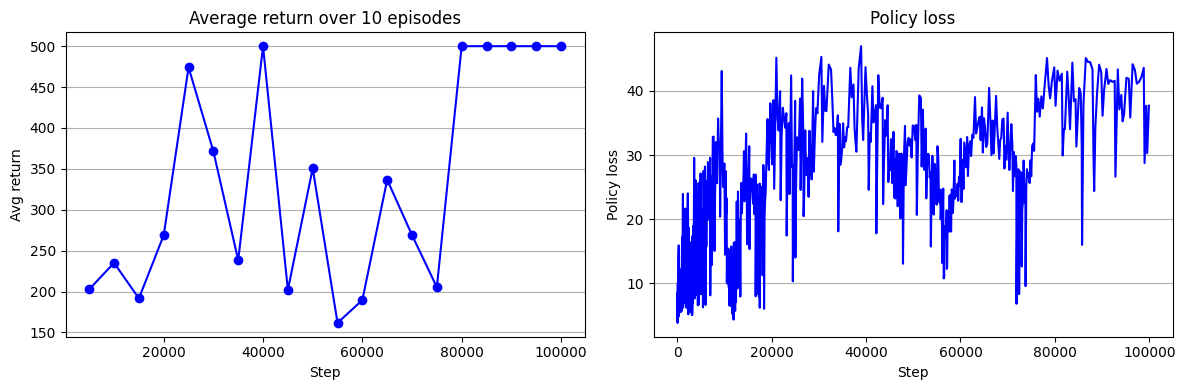

In [13]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'bo-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 2, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

fig.tight_layout()
plt.show()

<br>

---

## 연속 행동 공간

### 환경 알아보기

이번 절에서는 Pendulum 환경을 통해 연속 행동 공간에서 REINFORCE가 어떻게 구현되는지 알아볼 것이다. 



In [14]:
env = gym.make('Pendulum-v1')
s, _ = env.reset()

print("The dimension of state space: ", env.observation_space.shape[0])
print("The dimension of action space: ", env.action_space.shape[0])
print("Initial state: ", s)


The dimension of state space:  3
The dimension of action space:  1
Initial state:  [-0.98575884  0.16816504 -0.5445588 ]


<br>

### 정책 네트워크 구현

먼저, 정책 네트워크를 구현할 것이다. 정책 네트워크는 각 상태를 입력 받아서 행동 공간 내 모든 행동에 확률을 부여할 수 있어야 한다. 하지만, 연속 행동 공간의 경우 행동이 무수히 많아서 특정 행동에 확률을 부여할 수 없다. 연속 공간의 경우 확률 대신 확률 밀도 함수 (probability density function)를 사용한다. 우리는 상태에 따른 행동의 분포가 정규분포를 따른다고 가정할 것이다. 따라서 상태를 입력 받아 평균과 표준편차를 출력하는 정책 네트워크를 만들고, 출력된 평균과 표준편차를 따르는 정규 분포로부터 행동을 샘플링할 것이다.

In [15]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, dim_state, dim_action, dim_hiddens=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(dim_state, dim_hiddens[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(dim_hiddens) - 1):
            hidden_layer = nn.Linear(dim_hiddens[i], dim_hiddens[i+1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(dim_hiddens[-1], dim_action)
        self.log_std_layer = nn.Linear(dim_hiddens[-1], dim_action)
        self.activation_fn = activation_fn
        
    def forward(self, s):
        s = self.activation_fn(self.input_layer(s))
        for hidden_layer in self.hidden_layers:
            s = self.activation_fn(hidden_layer(s))
            
        mu = self.mu_layer(s)
        log_std = torch.tanh(self.log_std_layer(s))
        
        return mu, log_std.exp()

<br>

구현한 정책 네트워크를 선언하는 방법은 다음과 같다.

In [16]:
env = gym.make('Pendulum-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dims = (512, )
activation_fn = F.relu

policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn)
policy

MLPGaussianPolicy(
  (input_layer): Linear(in_features=3, out_features=512, bias=True)
  (hidden_layers): ModuleList()
  (mu_layer): Linear(in_features=512, out_features=1, bias=True)
  (log_std_layer): Linear(in_features=512, out_features=1, bias=True)
)

<br>

정책 네트워크로 만든 확률 분포에서 행동을 샘플링은 다음과 같이 할 수 있다. 
가장 마지막에 hyperbolic tangent (`torch.tanh`)는 뽑힌 행동이 -1과 1사이의 값을 갖게 만들어준다.
환경마다 선택할 수 있는 행동의 최소값과 최대값이 다른데, 행동을 먼저 -1과 1사이의 값으로 만들어 준 후 행동의 범위를 알맞게 조절하는 것이 편하다.

In [17]:
s, _ = env.reset()
s = torch.as_tensor(s, dtype=torch.float)

mu, std = policy(s)
a = torch.normal(mu, std)
a = torch.tanh(a)
a = a.cpu().detach().numpy()

max_action = env.action_space.high
min_action = env.action_space.low

a = 0.5 * (max_action - min_action) * (a + 1) + min_action

print("Selected action: ", a)


Selected action:  [-1.2416626]


```{note}
닫힌 구간 $[m, M]$에서 샘플링된 행동 $x$를 $[-1, 1]$ 안의 값으로 바꾸는 방법은 먼저 min-max normalization을 사용해서 $[0, 1]$의 값으로 변환한 후 2를 하고 -1을 빼주는 방식으로 진행된다. 즉,

$$x_{\text{norm}} = 2\frac{(x - m)}{(M - m)} - 1$$

그럼 $[-1, 1]$으로 normalize된 값 $x_{\text{norm}}$을 다시 원래의 범위 $[m, M]$로 돌리기 위해서는 다음과 같은 연산이 필요하다.

$$x = 0.5 \times \left( x_{\text{norm}} + 1 \right) \times (M - m) + m$$
```

<br>


### 에이전트 구현

우리는 일반적인 에이전트를 구현하는 것이 목표이기 때문에 이산 행동 공간에서 만들었던 REINFORCE에 코드를 추가하는 방식을 선택할 것이다.
이를 위해서 `__init__()` 메서드에서 `action_type` 인자를 넘겨 받을 것이고, `act()` 메서드와 `learn()` 메서드에서 `self.action_type` 속성에 따라 행동 선택 및 확률 계산을 따로 해줄 것이다.

In [18]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.001, action_type='continuous'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if action_type == 'discret':
            self.policy = MLPDiscretePolicy(state_dim, action_dim).to(self.device)
        else:
            self.policy = MLPGaussianPolicy(state_dim, action_dim).to(self.device)
        self.gamma = gamma
        self.action_type = action_type
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.buffer = []
        
    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        if self.action_type == 'discrete':
            prob = self.policy(s)
            a = torch.multinomial(prob, 1) if training else torch.argmax(prob, dim=-1, keepdim=True)

        else:
            mu, std = self.policy(s)
            z = torch.normal(mu, std) if training else mu
            a = torch.tanh(z)

        return a.cpu().numpy()

    def learn(self):
        self.policy.train()
        s, a, r, _, _, _ = map(np.stack, zip(*self.buffer))
        s, a, r = map(lambda x: torch.as_tensor(x, dtype=torch.float, device=self.device), [s, a, r])
        r = r.unsqueeze(1)
        
        ret = torch.clone(r)
        for t in reversed(range(len(ret) - 1)):
            ret[t] += self.gamma * ret[t + 1]
            
        if self.action_type == 'discrete':
            probs = self.policy(s)
            log_probs = torch.log(probs.gather(1, a.long()))
        else:
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
            log_probs = m.log_prob(z)
        
        policy_loss = - (ret * log_probs).mean()
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        result = {'policy_loss': policy_loss.item()}
        
        return result
        
    def process(self, transition):
        result = None
        self.buffer.append(transition)
        if transition[-1] or transition[-2]:
            result = self.learn()
            self.buffer = []
        return result


<br>

### 에이전트 훈련

다음으로 에이전트를 훈련시킬 것이다. `CartPole`에서 사용했던 코드에서 `env.step()` 호출 부분만 달라진다.
- Gymnasium의 경우, 이산 행동 공간을 갖는 환경은 스칼라 값을 받는 반면에 연속 행동 공간을 갖는 환경은 배열을 받는다. 한편, 우리의 정책은 항상 배열을 반환해준다. 따라서 `CartPole`에서는 배열의 원소를 인수로 주기 위하여 `env.step(a[0])` 호출했지만, `Pendulum` 환경에서는 에이전트가 주는 배열을 바로 인수로 넘겨준다.
- 우리의 에이전트는 -1과 1사이의 행동을 취한다. 하지만 `Gymnasium`의 `Pendulum` 환경의 행동 공간은 $[-2, 2]$이다. 따라서, `env.step()`에서 `2.0 * a`를 인수로 넘겨주었다. 

In [19]:
def evaluate(env_name, agent, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for _ in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=np.random.randint(10000)), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [20]:
env_name = 'Pendulum-v1'

seed = 0
max_iterations = 1000000
eval_intervals = 5000
eval_iterations = 10
gamma = 0.9
lr = 0.0003

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = REINFORCE(state_dim, action_dim, gamma, lr)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in range(1, max_iterations + 1):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.process((s, a, r, s_prime, terminated, truncated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

<br>

훈련 로그를 보면 다음과 같다. 결과 그래프에서 알 수 있는 것처럼 단순한 REINFORCE으로는 Pendulum 환경을 제어하기 어렵다. 
이후 장에서 에이전트를 조금씩 개선하며 Pendulum 환경을 제어해보자. Policy loss 그래픠 y축 스케일을 보자. $10^{10}$이다 ㅋㅋ.
이러니 학습이 될리가 있냐고~~~. 

<br>

이렇게 Policy loss가 큰 것은 우연이 아니다. 
강화학습에서 return인 $G_t$값이 무진장 크다. 정의 자체가 받은 보상들을 모두 합한 것이니 클 수 밖에 없다.
그러다 보니 그레디언트 값도 커질 뿐만 아니라, 그레디언트 추정치에 대한 분산도 굉장히 크다. 
다음장에서는 Baseline을 사용해서 REINFORCE를 개선해볼 것이다.

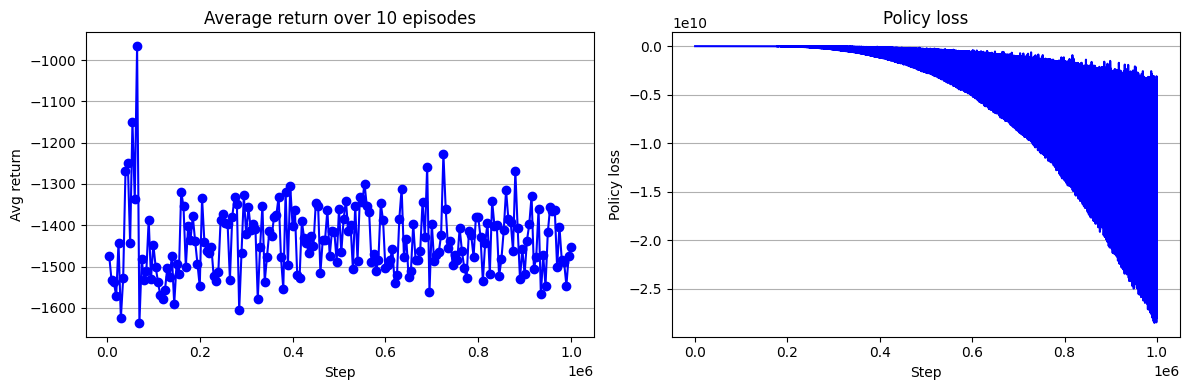

In [21]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'bo-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 2, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

fig.tight_layout()
plt.show()

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```